# Cleaning and Preprocessing

### Imports

https://github.com/sanjeevai/disaster-response-pipeline/blob/master/models/train_classifier.py

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import databases
import dataloader

## Import the data

In [3]:
subreddit_list = ['css', 'html', 'javascript', 'php', 'perl', 'java', 'datascience', 'machinelearning', 'etl', 'python']

In [4]:
# subreddit_list = ['datascience','sql']

In [5]:
df = dataloader.data_selector(subreddit_list, 'sqlite')

Connection to SQLite DB successful
No data for javascript, not adding to df
No data for php, not adding to df
No data for perl, not adding to df
No data for java, not adding to df
No data for etl, not adding to df
No data for python, not adding to df


In [6]:
subreddit_list = [sub for sub in subreddit_list if sub in df.subreddit.unique()]

In [7]:
subreddit_list

['css', 'html', 'datascience', 'machinelearning']

In [8]:
df = dataloader.subreddit_encoder(df)

Topic dict to make sure: {'datascience': 0, 'html': 1, 'css': 2, 'machinelearning': 3}


In [9]:
df.sample(10)

,title,subreddit,date,sub_code
3773,CSSYBERTRUCK,css,2020-03-10,2
2323,What to expect for a phone interview for Data ...,datascience,2020-03-10,0
1175,Great way to get practice/build my data scienc...,datascience,2020-03-10,0
2626,Need help with wrong class labels,datascience,2020-03-10,0
4598,What's the best way to combine all rendered CS...,css,2020-03-10,2
2123,Creating a customer attrition model for my work.,datascience,2020-03-10,0
6479,Is publication a part of your job ? What indus...,datascience,2020-03-10,0
2665,Want to buy the book ISLR - Introduction to St...,datascience,2020-03-10,0
5481,[Discussion] Faster training in DDPG,machinelearning,2020-03-10,3
1590,Starting Master of IT in Data Science soon wit...,datascience,2020-03-10,0


In [10]:
X = df['title']
y = df['sub_code']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [12]:
useless_words = set(['using', 'help', 'new', 'data', 'science', 'machine', 'learning'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [13]:
pipe = Pipeline([('count_vec', CountVectorizer()), ('lr', LogisticRegression())])

In [14]:
pipe_params = {
                'count_vec__max_features': [4000],
                'count_vec__max_df': [.3],
                'count_vec__ngram_range': [(1,2)],
                'count_vec__stop_words': [custom_stop_words],
                'count_vec__min_df': [3],
                'lr__penalty': ['l2'],
                'lr__C': [5]
                }

In [15]:
model = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose=1, n_jobs=-1)

In [16]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
/Users/chris/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('count_vec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                       

In [17]:
model.best_params_

{'count_vec__max_df': 0.3,
 'count_vec__max_features': 4000,
 'count_vec__min_df': 3,
 'count_vec__ngram_range': (1, 2),
 'count_vec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
    

In [18]:
print(f'Best Modeling Score: {model.best_score_}')

print(f'Train Score: {model.score(X_train, y_train)}')

print(f'Test Score: {model.score(X_test, y_test)}')

Best Modeling Score: 0.8131338228614997
Train Score: 0.9649371706526145
Test Score: 0.8328267477203647


In [19]:
# model is GridSearchCV
# best_estimator is Pipeline
# named_steps is the steps in the pipeline
# count_vec is the FITTED 

features_data = model.best_estimator_.named_steps.count_vec.transform(X).toarray()
features_columns = model.best_estimator_.named_steps.count_vec.get_feature_names()
features_df = pd.DataFrame(data=features_data, columns=features_columns)

## You know what would be cool?  Stacked bar graph of all of them!!

In [ ]:
### CHECK ### does this function work with tfidf, or just count vec?
###HELP### this kinda looks like shit when only using 3 features, 2 columns if features below X value?
def plot_most_common(df, features_df, num_features=20, standardize=False, include_combined=False):
    '''
    Plots the most common features for each subreddit in the DataFrame
    
    Parameters:
    
    df: original DataFrame
    
    features_df: should be output from transformer on df
        
        Example:
        features_df = pd.DataFrame(
                                data={transformer}.transform(X).toarray(),
                                columns={transformer}.get_feature_names())
    
    num_features: number of most common features to plot for each subreddit
    
    standardize: put all of the plots on the same scale
    
    combined: include a plot of the most common features of all of the subreddits combined
    
    Returns:
    
    plots
    
    '''

    fig, ax = plt.subplots(ncols=1, 
                           nrows=len(subreddit_list) + int(1 if include_combined else 0), 
                           figsize=(15, num_features/1.5*len(subreddit_list)))

    for subplot_idx, sub in enumerate(subreddit_list):
        sub_features = features_df.loc[df['subreddit'] == sub]
        sub_top_words = sub_features.sum().sort_values(ascending=False).head(num_features)[::-1]
        sub_top_words.plot(kind='barh', ax=ax[subplot_idx])
        ax[subplot_idx].set_title(f'{num_features} Most Common Words for {sub.upper()}', fontsize=16)
        if standardize:
            max_occurence = features_df.sum().max()
            ax[subplot_idx].set_xlim(0,max_occurence)

    if include_combined:
        most_common = features_df.sum().sort_values(ascending=False).head(num_features)[::-1]
        most_common.plot(kind='barh', ax=ax[subplot_idx+1])
        ax[subplot_idx+1].set_title(f'{num_features} Most Common Words for {subreddit_list}')
        if standardize:
            max_occurence = features_df.sum().max()
            ax[subplot_idx+1].set_xlim(0,max_occurence)
    plt.tight_layout()

In [ ]:
plot_most_common(df, features_df, num_features=20, include_combined=True)

## Feature Importance Coefficients

In [ ]:
###HELP### I don't think this is working right

In [ ]:
###NOTE### coefficients only for lr and etc etc etc...
###NOTE### coefficients only for two subreddits


# [-1][1] for last step (estimator)(instantiation)
# coef_[0]because I don't know why
coefs = model.best_estimator_.steps[-1][1].coef_[0]




plt.figure(figsize=(16, 12))
plt.title('Feature Importance (Coefficients)', fontsize=20)
plt.ylabel('Features', fontsize=18)
plt.xlabel('(Abs) Coefficients', fontsize=18)

coef_df = pd.DataFrame(data=[coefs], columns=features_columns).T
coef_df['abs_coef'] = coef_df[0].abs()
coef_df.sort_values('abs_coef', ascending=False)[0].head(15).plot(kind='barh');

# coef_kill = coef_df.sort_values('abs_coef', ascending=False)[0].head(500).index

# coef_kill


# my_stops.extend(coef_kill)

In [ ]:
from itertools import combinations

In [ ]:
def make_pairs(subreddit_list):
    '''
    Makes combination pairs of subreddits from subreddit_list
    '''
    if len(subreddit_list) > 2:
            return list(combinations(subreddit_list,2))
    return subreddit_list

In [ ]:
pairs = make_pairs(subreddit_list)

In [ ]:
def plot_most_common_pairs(df, features_df, pairs, num_features=20):
    '''
    Plots the most common features for each subreddit in the DataFrame
    
    Parameters:
    
    df: original DataFrame
    
    features_df: should be output from transformer on df
        
        Example:
        features_df = pd.DataFrame(
                                data={transformer}.transform(X).toarray(),
                                columns={transformer}.get_feature_names())
    
    num_features: number of most common features to plot for each subreddit
    
    Returns:
    
    plots
    
    '''
    fig, ax = plt.subplots(ncols=2, 
                           nrows=len(sub_combos), 
                           figsize=(16,num_features/3*len(sub_combos)))

    num_features = 20
    for i, pair in enumerate(sub_combos):

        # features for each pair
        feats_0 = features_df.loc[(df['subreddit'] == pair[0])]
        feats_1 = features_df.loc[(df['subreddit'] == pair[1])]
        # combined
        common_feats = feats_0.append(feats_1)
        # this is the most common between the two
        most_common = common_feats.sum().sort_values(ascending=False).head(num_features)[::-1]
        # plot
        feats_0[most_common.index].sum().plot.barh(ax=ax[i, 0], color='navy')
        feats_1[most_common.index].sum().plot.barh(ax=ax[i, 1], color='orange')
        ax[i, 0].set_title(f'Top {num_features} - {pair} \nSub: {pair[0].upper()}', fontsize=16, wrap=True)
        ax[i, 1].set_title(f'Top {num_features} - {pair} \nSub: {pair[1].upper()}', fontsize=16, wrap=True)
        max_occurence = common_feats.sum().max()
        ax[i, 0].set_xlim(0,max_occurence)
        ax[i, 1].set_xlim(0,max_occurence)
    plt.tight_layout()

In [ ]:
plot_most_common_pairs(df, features_df, pairs)

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))


groups = features_df.groupby(df['subreddit']).sum()[most_common.index].T.head(20)
plt.title('20 Most Common Words', fontsize=20)

groups.plot.bar(
                ax=ax,
                width=.8,
                # set style for colors instead of have to choose individually
                color=['gray','navy','orange','purple','red'],
                fontsize=15,
                );

# Word Clouds!!!

### Entire dataset

In [ ]:
make_cloud(X)

In [ ]:
def make_all_clouds(subreddit_list):
    '''
    Makes seperate word clouds for each subreddit in the list
    '''
    fig = plt.figure(figsize=(14, 6*len(subreddit_list)))
    for i, sub in enumerate(subreddit_list):
        ax = fig.add_subplot(len(subreddit_list),1,i+1)
        cloud = make_cloud(X=df[df['subreddit'] == sub]['title'])


        ax.set_title(sub.upper(), fontdict={'fontsize': 24})
        ax.imshow(cloud)
        ax.axis('off')


In [ ]:
make_all_clouds(subreddit_list)

## To Do for this section

1. Confusion Matrix for all selected Topics
2. Make a function that will compare all topics in 1x1 fasion, find combinatorics or whatever Python library
3. Output each of the comparisons if a list of more than 2.

## Confusion Matrix

In [20]:
y_pred = model.predict(X_test)

In [21]:
cm = confusion_matrix(y_test, y_pred)

In [22]:
df_cm = pd.DataFrame(cm, columns=subreddit_list, index=subreddit_list)
df_cm

,css,html,datascience,machinelearning
css,874,15,1,0
html,7,190,60,6
datascience,19,62,138,10
machinelearning,59,29,7,168


In [23]:
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

[Text(0, 0.5, 'css'),
 Text(0, 1.5, 'html'),
 Text(0, 2.5, 'datascience'),
 Text(0, 3.5, 'machinelearning')]

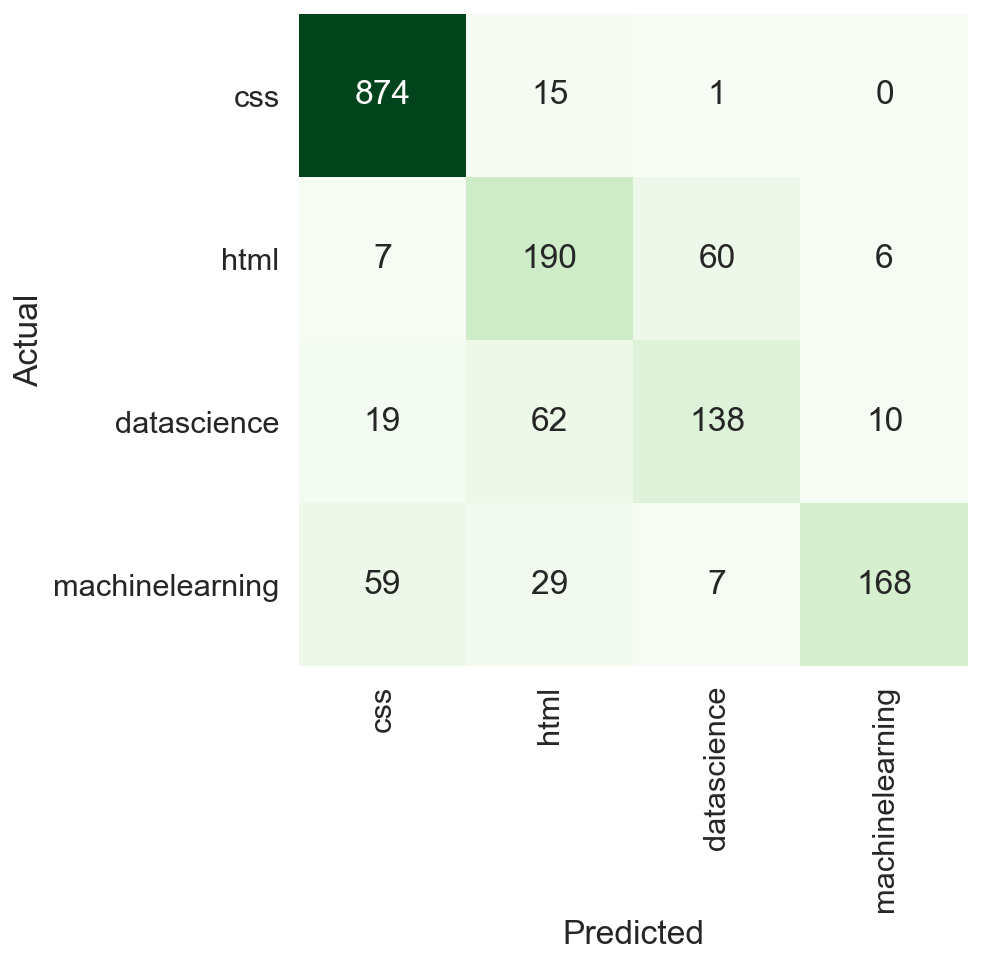

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4, )#for label size
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap='Greens', ax=ax)
ax.set_yticklabels(labels=subreddit_list, rotation='horizontal')

In [31]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
mtn = mcm[:, 0, 0]
mtp = mcm[:, 1, 1]
mfn = mcm[:, 1, 0]
mfp = mcm[:, 0, 1]

In [32]:
mcm

array([[[ 670,   85],
        [  16,  874]],

       [[1276,  106],
        [  73,  190]],

       [[1348,   68],
        [  91,  138]],

       [[1366,   16],
        [  95,  168]]])

In [37]:
cmaps = ['BuGn_r','Blues','YlGnBu','Blues_r']

Subreddit: CSS
Specificity: 0.8874
Sensitivity: 0.982

Subreddit: HTML
Specificity: 0.9233
Sensitivity: 0.7224

Subreddit: DATASCIENCE
Specificity: 0.952
Sensitivity: 0.6026

Subreddit: MACHINELEARNING
Specificity: 0.9884
Sensitivity: 0.6388



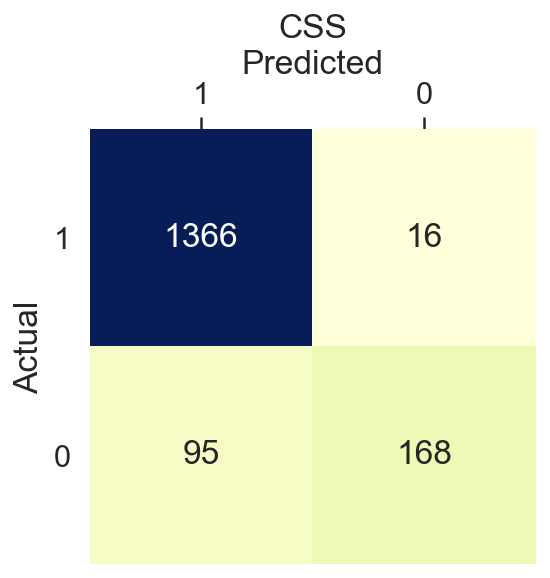

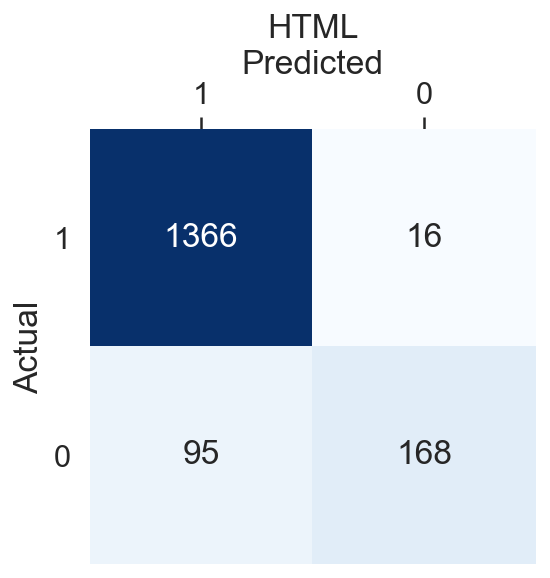

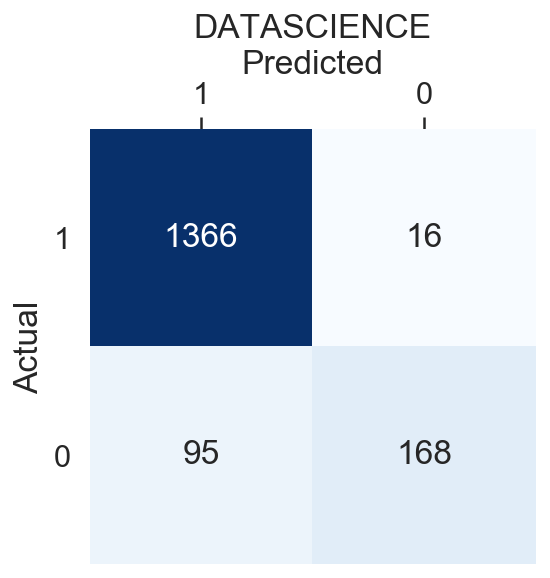

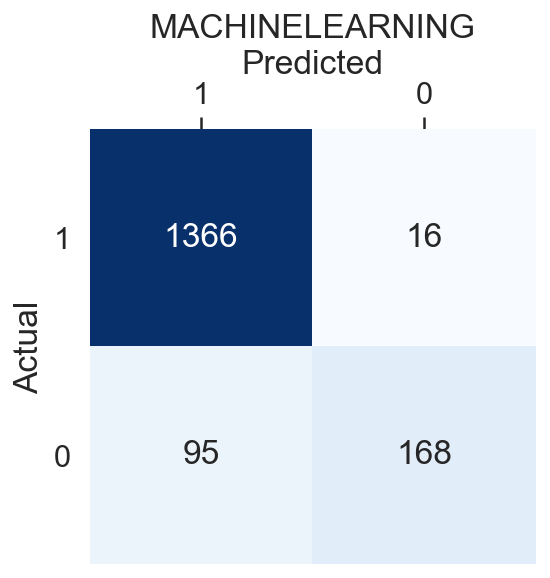

In [60]:
for i, cm in enumerate(mcm):
    print(f'Subreddit: {subreddit_list[i].upper()}')
    
    fig, ax = plt.subplots(figsize=(4,4))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap=np.random.choice(cmaps), ax=ax)
    ax.set_yticklabels(labels=[1,0], rotation='horizontal')
    ax.set_xticklabels(labels=[1,0])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_title(subreddit_list[i].upper())

    tn, fp, fn, tp = cm.ravel()
    specif = tn / (tn + fp)
    print(f'Specificity: {round(specif,4)}')
    sens = tp / (tp +fn)
    print(f'Sensitivity: {round(sens,4)}')
    print()
    


In [ ]:
print(classification_report(y_test, y_pred, digits=3, target_names=subreddit_list))

### ROC AUC Score

TODO:

1. Make it have the roc for each sub, have to get into the original df where subname equals indexes?
2. Plot confusion matrix
3. Make a notebook to test the confusion matrixes one by one with each individual model.

In [ ]:
y_test.index

In [ ]:
auc = roc_auc_score(y_test, predictions)
auc

### ROC AUC Curve

In [ ]:
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# not multiclass
fpr, tpr, thresholds = roc_curve(y_test, probs)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

# Histograms!

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(probs, bins=25, color='b')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(lr_probs[y_test == 0],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(lr_probs[y_test == 1],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)